# Assignment 2: PCA
**Data:**
Dataset obtained from Credit Card Dataset for Clustering | Kaggle. Original source unknown. The dataset file is attached below for download. 

**Problem Statement:**
The marketing department of a credit card company wants to better understand the different types of customers they serve, in order to design marketing strategies that target each group more effectively. As a data scientist, your task is to investigate whether PCA can improve the clustering results and visualization. In the end, you will need to describe each customer group in a way that provides useful insights to the marketing team. 


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
import numpy as np

# 1. Data

In [2]:
url = "https://raw.githubusercontent.com/Hunteracademic/Unsupervised_assignment_1/master/CCGENERAL.csv"
credit_data = pd.read_csv(url)
credit_data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
credit_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


# Column Descriptions

### Credit Card Dataset: Column Guide
These definitions are based on the standard CC GENERAL data used for customer segmentation and behavior analysis (Bhasin, 2017). 

### The Basics
- CUST_ID: Just a unique ID for each cardholder. It’s categorical, so don't try to run any math on it.

- BALANCE: The average amount the customer carries on their card month-to-month.

- BALANCE_FREQUENCY: A score from 0 to 1 showing how often the balance actually changes. A "1" means their balance updates every single month; lower scores mean the account is relatively inactive.

- TENURE: How long they’ve been a customer (usually ranges from 6 to 12 months in this specific set).

### Spending Habits 
- PURCHASES: Total spend over the last year.

- ONEOFF_PURCHASES: Total amount spent on "lump sum" or single transactions (no installments).

- INSTALLMENTS_PURCHASES: Total spend specifically handled through monthly payment plans.

- CASH_ADVANCE: Total cash the customer withdrew from the card (essentially a short-term loan).

### Activity & Frequency
<!-- All "Frequency" columns are scaled from 0 to 1. Think of 1 as "happening constantly" and 0 as "never happened." -->

- PURCHASES_FREQUENCY: How often they use the card for any purchase.

- ONEOFF_PURCHASES_FREQUENCY: How often they make those big, single purchases.

- PURCHASES_INSTALLMENTS_FREQUENCY: How frequently they opt for installment-based payments.

- CASH_ADVANCE_FREQUENCY: How often they take out cash advances.

- PURCHASES_TRX: The raw count of total purchase transactions.

- CASH_ADVANCE_TRX: The raw count of total cash advance transactions.

### Credit & Repayment
- CREDIT_LIMIT: The maximum spending limit set by the bank.

- PAYMENTS: Total amount the customer paid back over the last 12 months.

- MINIMUM_PAYMENTS: The portion of their payments that went toward the "minimum due" amount.

- PRC_FULL_PAYMENT: The percentage of months where the customer paid off their entire balance rather than just the minimum. This is a great indicator of financial health


In [4]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## Cleaning

In [5]:
print("--- Duplicate Row Report ---")
print(f"Duplicates found: {credit_data.duplicated().sum()}")

print("-" * 30) # Prints a line of 30 dashes

print("--- Missing Value Report ---")
print(credit_data.isna().sum()[credit_data.isna().sum() > 0])

--- Duplicate Row Report ---
Duplicates found: 0
------------------------------
--- Missing Value Report ---
CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64


In [6]:
credit_data['MINIMUM_PAYMENTS'] = credit_data['MINIMUM_PAYMENTS'].fillna(credit_data['MINIMUM_PAYMENTS'].median())
credit_data['CREDIT_LIMIT'] = credit_data['CREDIT_LIMIT'].fillna(credit_data['CREDIT_LIMIT'].median())

# Verify that there are no missing values left
print("Missing values after fix:", credit_data.isna().sum().sum())

print("--- Missing Value Report ---")
print(credit_data.isna().sum()[credit_data.isna().sum() > 0])

Missing values after fix: 0
--- Missing Value Report ---
Series([], dtype: int64)


We went with median imputation for the missing values because only a small number of records were missing, so it didn't make sense to just delete them and lose that data. Also, since financial data usually has a few extreme outliers, using the median is a lot safer and keeps our results more accurate than using the mean (ApX Machine Learning, 2026)

In [7]:
Cust_id = credit_data["CUST_ID"]

clean_cust_id = credit_data.drop(["CUST_ID"], axis=1)
clean_cust_id = clean_cust_id.reset_index(drop=True)
clean_cust_id.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### Dropping unneeded columns:

- CUST_ID: This is just an identifier column, we are storing in in a separate database for mapping at a later stage 


### Heatmap

Text(0.5, 1.0, 'Correlation Heatmap of Credit Data')

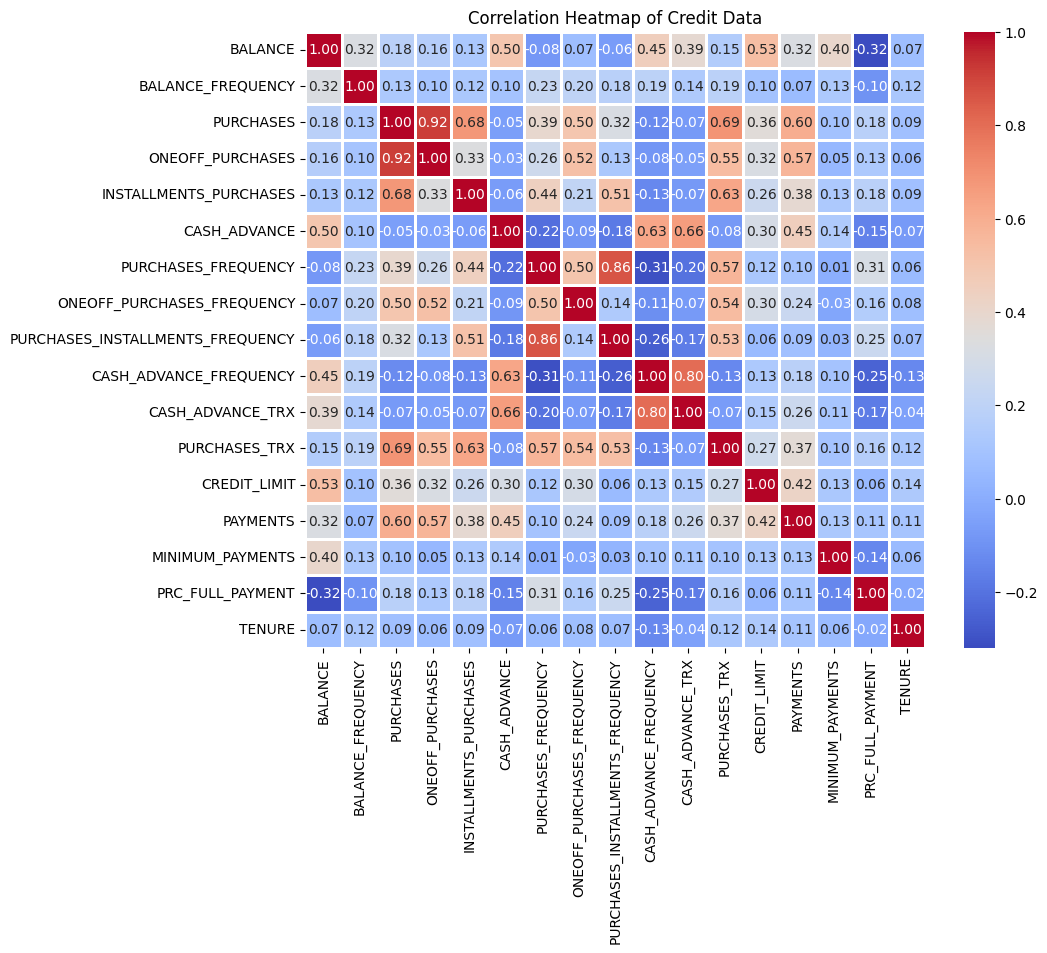

In [8]:
corr = clean_cust_id.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=1
)
plt.title("Correlation Heatmap of Credit Data")

In [9]:
#sns.pairplot(clean_cust_id)

# Credit Card Behavior Analysis

## Purchase Patterns

**One-off vs. Installment Purchases**
- One-off purchases make up the vast majority of total purchases (0.92 correlation), while installments contribute moderately (0.68 correlation)
- Customers who buy frequently also use installments frequently (0.86 correlation), suggesting installment users are generally active shoppers

**Purchase Frequency & Balance**
- Higher account balances slightly reduce purchase activity (-0.18 correlation), indicating customers carrying larger balances may be more cautious about new spending

## Cash Advance Behavior

**Cash Advances Are Separate from Purchases**
- Customers who take cash advances tend to purchase less frequently (-0.22 correlation)
- Cash advance frequency strongly predicts cash advance transaction count (0.80 correlation)—this behavior is consistent within customer groups
- Higher balances are associated with fewer cash advances (-0.50 correlation), suggesting financially strained customers may rely more on this feature

## Payment Patterns

**Credit Limit Matters**
- Higher credit limits correlate with larger payment amounts (0.42 correlation), likely reflecting higher spending capacity

**Minimum Payments Are Independent**
- Minimum payment behavior shows weak correlations across most variables, suggesting it's driven by different factors than purchasing or cash advance patterns
- Customers making minimum payments are slightly less likely to pay their full balance (-0.14 correlation)


# 2. PCA

In [10]:
scaler = MinMaxScaler()
# Fit dataset into new variable using scaler
scaled_x = scaler.fit_transform(clean_cust_id)
# create dataframe with index and column names
df_scaled = pd.DataFrame(scaled_x, columns=clean_cust_id.columns, index=clean_cust_id.index)
df_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.004088,0.000000,1.0
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0


b) Use sklearn.decomposition.PCA.fit_transform to do a PCA transformation on the data without specifying the number of components. Print out the explained variance ratios and determine how many components are required to retain at least 95% of the explained variance.

In [11]:
model = PCA()
data_t = model.fit_transform(df_scaled.values)
model.explained_variance_ratio_.cumsum()

array([0.49597096, 0.63651215, 0.76495822, 0.84172674, 0.91136225,
       0.94724536, 0.96543793, 0.97896669, 0.98552154, 0.9910304 ,
       0.99387161, 0.99573003, 0.99699706, 0.99822282, 0.99927985,
       0.99999997, 1.        ])

### Number of selected components: 7
-
-
-


c) Perform PCA again with n_components set to retain 95% of the explained variance, and save the transformed data to a new DataFrame.

In [12]:
model_2 = PCA(n_components=7)
data_t_2 = model_2.fit_transform(df_scaled.values)
model_2.explained_variance_ratio_.cumsum()

array([0.49597096, 0.63651215, 0.76495822, 0.84172674, 0.91136225,
       0.94724536, 0.96543793])

In [13]:
data_t_2_df = pd.DataFrame(data_t_2, columns=[f"PC{i+1}" for i in range(data_t_2.shape[1])])
data_t_2_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.482168,-0.097653,-0.046473,0.058293,-0.109979,-0.171672,-0.018602
1,-0.608575,-0.019376,0.082109,0.218748,0.099024,0.137029,-0.047467
2,0.304508,0.920934,0.012204,-0.160033,-0.162325,-0.158527,0.006547
3,-0.588622,-0.005631,0.037055,-0.004430,-0.223708,0.065366,-0.096132
4,-0.554357,0.052978,-0.084182,0.132827,0.017081,-0.204461,-0.056412
...,...,...,...,...,...,...,...
8945,0.646916,-0.463095,0.210333,-0.613566,0.663510,-0.149584,-0.086299
8946,0.549889,-0.406725,-0.214439,-0.779995,0.505241,-0.193648,-0.101667
8947,0.360383,-0.422686,0.105869,-0.744952,0.480295,-0.135270,-0.090536
8948,-0.646100,-0.204392,0.281758,-0.633023,0.571143,-0.104927,-0.095782


Create at least 12 clustering models using K-Means, Hierarchical, and DBSCAN, experimenting with different hyperparameter choices.
Calculate the silhouette score for each model and tabulate the results.

# 3. Clustering
## 3.a Creating Different Models using DBSCAN, Agglomerative Clustering and K-means
Create at least 12 clustering models using K-Means, Hierarchical, and DBSCAN, experimenting with different hyperparameter choices. 

### DBSCAN

In [38]:
from sklearn.cluster import DBSCAN

# Possible values to make up a grid search
small_eps      = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
small_samples  = [5, 10, 15, 20, 25]
high_samples   = [30, 35, 40, 45, 50]
giant_samples  = [90, 100, 150, 160, 170, 174, 200]
metrics = ['euclidean', 'manhattan', 'chebyshev']

n_records = scaled_x.shape[0]
max_noise_ratio = 0.25 # Setting up a maximum level of noise acceptable for a clustering to be considered valid

def run_grid(eps_list, samples_list, metrics, verbose=True):
    """ Running the grid search on defined parameters. Only prints results
    that contain more than 2 clusters for quality purposes

    Args:
        eps_list (list): Different epsilon values to try
        samples_list (list): Different min_samples to try
        metrics (list): The distance metrics to use
        name (str): The name of the combination when printed
    Returns:
        list: dictionary with all the results that passed the filters
    """
    results = []
    for metric in metrics:
        for eps in eps_list:
            for ms in samples_list:
                db = DBSCAN(eps=eps, min_samples=ms, metric=metric)
                labels = db.fit_predict(data_t_2_df)

                n_clusters = len(set(labels) - {-1})
                n_noise = np.sum(labels == -1)
                noise_ratio = n_noise / n_records

                # compute silhouette only if ≥2 clusters (ignoring noise)
                labels_no_noise = labels[labels != -1]
                X_no_noise = data_t_2_df[labels != -1]
                if len(np.unique(labels_no_noise)) >= 2:
                    sil = silhouette_score(X_no_noise, labels_no_noise, metric=metric)
                else:
                    sil = None

                # # apply filters:
                if sil is not None and noise_ratio <= max_noise_ratio:
                    # Storing in a dict for later use
                    results.append({
                        "metric": metric,
                        "eps": eps,
                        "min_samples": ms,
                        "n_clusters": n_clusters,
                        "n_noise": n_noise,
                        "noise_ratio": noise_ratio,
                        "silhouette": sil,
                        "labels": labels
                    })
    return results

In [39]:
# Execution with small eps and small samples, testing all metrics
show_results_1 = pd.DataFrame(run_grid(small_eps, small_samples, metrics))
show_results_1.drop(columns=["labels"], inplace=True) # Removing labels from the DataFrame for better readability
show_results_1

,metric,eps,min_samples,n_clusters,n_noise,noise_ratio,silhouette
0,manhattan,0.7,5,2,89,0.009944,0.263739


In [16]:
# Execution with small eps and high samples, testing all metrics
show_results_2 = pd.DataFrame(run_grid(small_eps, high_samples,  metrics))
show_results_2.drop(columns=["labels"], inplace=True) # Removing labels from the DataFrame for better readability
show_results_2

KeyError: "['labels'] not found in axis"

In [ ]:
# Execution with small eps and giant samples, testing all metrics
show_results_3 = pd.DataFrame(run_grid(small_eps, giant_samples,  metrics))
show_results_3.drop(columns=["labels"], inplace=True) # Removing labels from the DataFrame for better readability
show_results_3

In [15]:
eps = [0.7,0.9,1,1.1,1.2]
samples = [5,10,15,20,25]
for e in eps:
    for sample in samples:
        db = DBSCAN(eps=e, min_samples=sample, metric='manhattan')
        label = db.fit_predict(data_t_2_df) # Get the labels for the best combination of eps and min_samples
        dbscan_df = data_t_2_df.copy() # Create a copy of the original DataFrame to avoid modifying it
        dbscan_df["cluster"] = label
        sil_score = silhouette_score(dbscan_df, label, metric="euclidean")
        print(f"model: epsilon= {e}, min_samples: {sample}, sil:{sil_score}")

model: epsilon= 0.7, min_samples: 5, sil:0.35555454027850225
model: epsilon= 0.7, min_samples: 10, sil:0.389216624485219
model: epsilon= 0.7, min_samples: 15, sil:0.38648545434851067
model: epsilon= 0.7, min_samples: 20, sil:0.3845930157424963
model: epsilon= 0.7, min_samples: 25, sil:0.38260742516476803
model: epsilon= 0.9, min_samples: 5, sil:0.43220353904476305
model: epsilon= 0.9, min_samples: 10, sil:0.43147432964285676
model: epsilon= 0.9, min_samples: 15, sil:0.42272180807883336
model: epsilon= 0.9, min_samples: 20, sil:0.41935868470723014
model: epsilon= 0.9, min_samples: 25, sil:0.4212868406890441
model: epsilon= 1, min_samples: 5, sil:0.4364005080998824
model: epsilon= 1, min_samples: 10, sil:0.43278475211610157
model: epsilon= 1, min_samples: 15, sil:0.43802824130942963
model: epsilon= 1, min_samples: 20, sil:0.4383983771280547
model: epsilon= 1, min_samples: 25, sil:0.43721743005240354
model: epsilon= 1.1, min_samples: 5, sil:0.4329822864168763
model: epsilon= 1.1, min_samp

In [35]:
# model: epsilon= 1.1, min_samples: 20, sil:0.32817001615683683
# manhattan	ep: 1.0	min_samples: 10
db = DBSCAN(eps=0.3, min_samples=3, metric='euclidean')
label = db.fit_predict(data_t_2_df) # Get the labels for the best combination of eps and min_samples
dbscan_test_df = data_t_2_df.copy() # Create a copy of the original DataFrame to avoid modifying it
dbscan_test_df["cluster"] = label

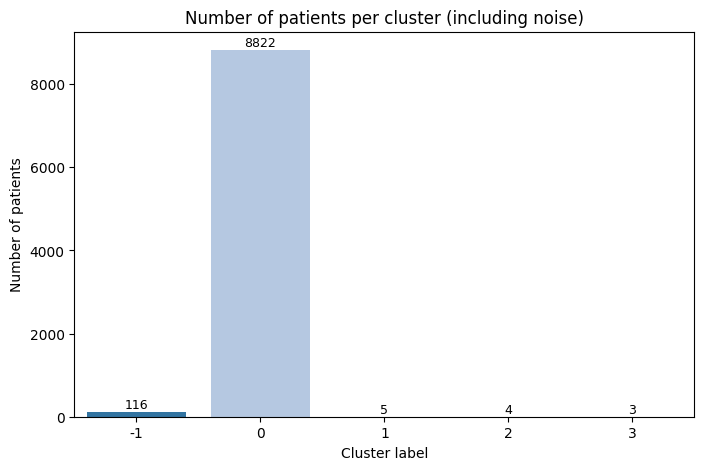

In [36]:
cluster_counts = dbscan_test_df['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=cluster_counts.index, 
                 y=cluster_counts.values, 
                 palette='tab20',
                 hue=cluster_counts.index,
                 legend=False)

for i, value in enumerate(cluster_counts.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=9)

plt.xlabel('Cluster label')
plt.ylabel('Number of patients')
plt.title('Number of patients per cluster (including noise)')
plt.show()

### Hierarchical

In [17]:
methods = ['ward', 'single', 'average', 'complete']

# Evaluate different clustering models using silhouette scores - Metric Euclidean
scipy_models_euclidean = {}
for method in methods:
    for t in range(2, 7):
        model = fcluster(linkage(data_t_2, method=method, metric='euclidean'), t, criterion='maxclust')
        sil_score = silhouette_score(data_t_2, model, metric="euclidean")
        scipy_models_euclidean[(method, t)] = (sil_score, model)

# Evaluate different clustering models using silhouette scores - Metric Manhattan
scipy_models_manhattan = {}
for method in methods:
    for t in range(2, 7):
        if method == 'ward':
            continue  # Ward linkage is not defined for Manhattan distance
        model = fcluster(linkage(data_t_2, method=method, metric='cityblock'), t, criterion='maxclust')
        sil_score = silhouette_score(data_t_2, model, metric="manhattan")
        scipy_models_manhattan[(method, t)] = (sil_score, model)

In [18]:
# Removing cluster labels from the dictionary for DataFrame creation
restructured_scipy_models_euclidean = {k: v[0] for k, v in scipy_models_euclidean.items()}
# Creating DataFrame for Euclidean results
scipy_dfs_models_euclidean = pd.DataFrame.from_dict(restructured_scipy_models_euclidean, orient='index', columns=['Silhouette Score'])
scipy_dfs_models_euclidean.index = pd.MultiIndex.from_tuples(scipy_dfs_models_euclidean.index, names=['Method', 'n_clusters'])
scipy_dfs_models_euclidean.reset_index(inplace=True)
scipy_dfs_models_euclidean.pivot(index='n_clusters', columns='Method', values='Silhouette Score')

# Creaeting DataFrame for Manhattan results
restructured_scipy_models_manhattan = {k: v[0] for k, v in scipy_models_manhattan.items()}
scipy_dfs_models_manhattan = pd.DataFrame.from_dict(restructured_scipy_models_manhattan, orient='index', columns=['Silhouette Score'])
scipy_dfs_models_manhattan.index = pd.MultiIndex.from_tuples(scipy_dfs_models_manhattan.index, names=['Method', 'n_clusters'])
scipy_dfs_models_manhattan.reset_index(inplace=True)
scipy_dfs_models_manhattan.pivot(index='n_clusters', columns='Method', values='Silhouette Score')

# Joining both DataFrames for comparison
scipy_dfs_combined = scipy_dfs_models_euclidean.merge(
    scipy_dfs_models_manhattan,
    how='left',
    on=['Method', 'n_clusters'],
    suffixes=('_euclidean', '_manhattan')
)
scipy_dfs_combined.pivot(index='n_clusters', columns='Method', values=['Silhouette Score_euclidean', 'Silhouette Score_manhattan'])
#scipy_dfs_combined[(scipy_dfs_combined['n_clusters'] == 5) | (scipy_dfs_combined['n_clusters'] == 3) | (scipy_dfs_combined['n_clusters'] == 4)].sort_values(by='Silhouette Score_euclidean', ascending=False)
scipy_dfs_combined

,Method,n_clusters,Silhouette Score_euclidean,Silhouette Score_manhattan
0,ward,2,0.339730,NaN
1,ward,3,0.309257,NaN
2,ward,4,0.262579,NaN
3,ward,5,0.231666,NaN
4,ward,6,0.245293,NaN
5,single,2,0.397625,0.465501
6,single,3,0.268030,0.360443
7,single,4,0.253518,0.299854
8,single,5,0.243646,0.289297
9,single,6,0.228178,0.271308


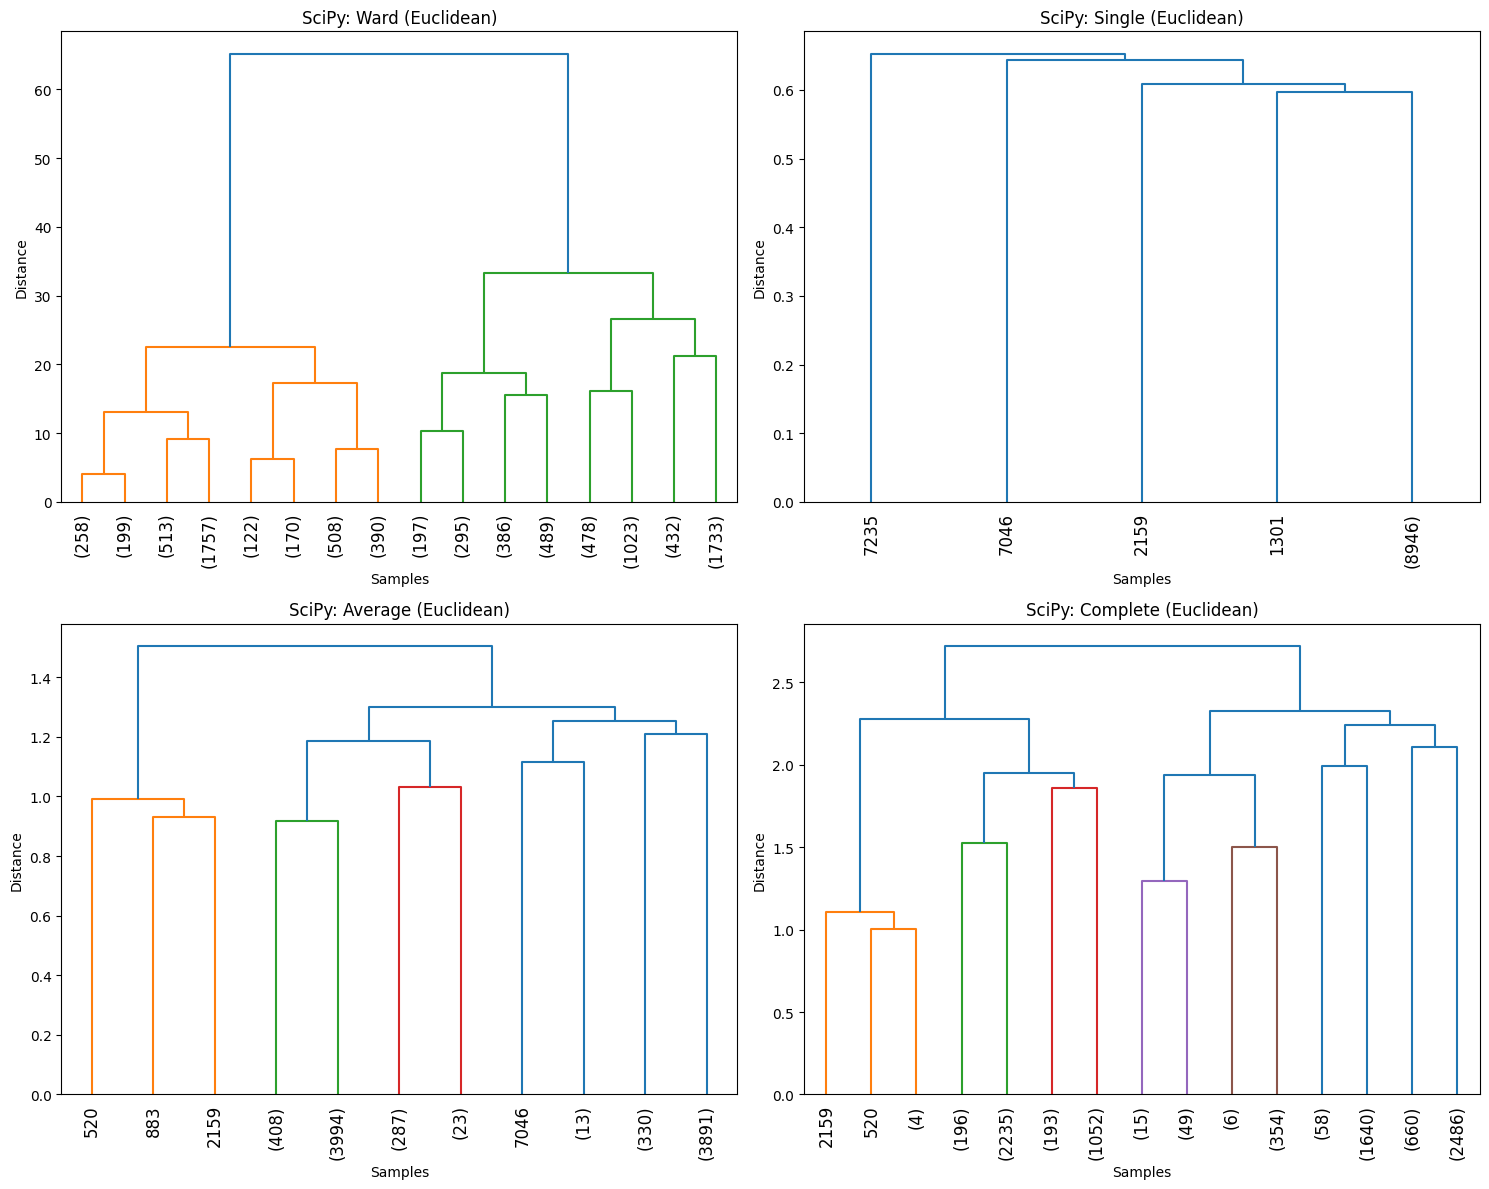

In [19]:
methods = ['ward', 'single', 'average', 'complete']

# SciPy Euclidean dendrograms
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, method in enumerate(methods):
    Z = linkage(data_t_2, method=method, metric='euclidean')
    dendrogram(Z, ax=axes[i], truncate_mode='level', p=3, leaf_rotation=90)
    axes[i].set_title(f'SciPy: {method.capitalize()} (Euclidean)')
    axes[i].set_xlabel('Samples')
    axes[i].set_ylabel('Distance')

plt.tight_layout()
plt.show()

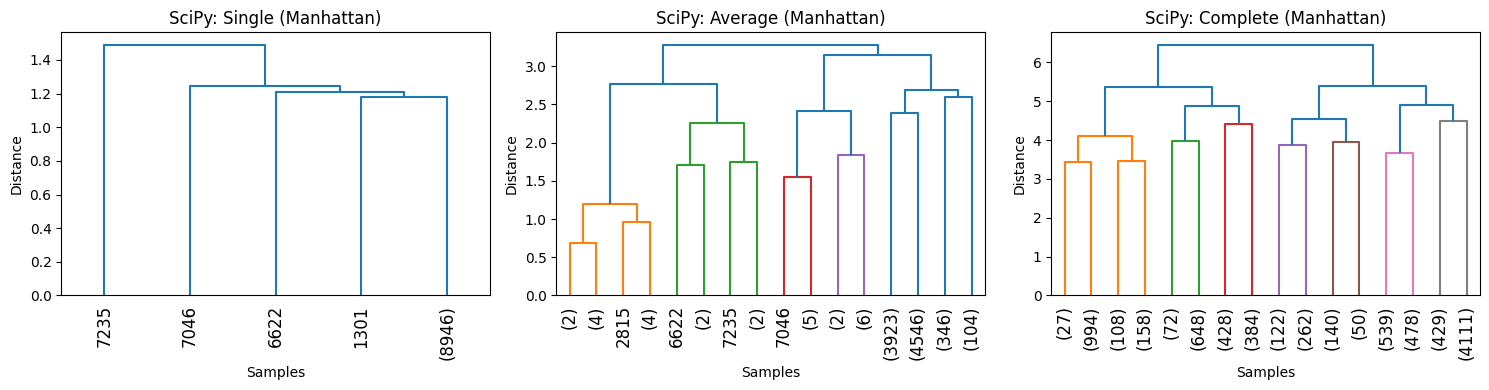

In [20]:
# SciPy Manhattan dendrograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
manh_methods = ['single', 'average', 'complete']

for i, method in enumerate(manh_methods):
    Z = linkage(data_t_2, method=method, metric='cityblock')
    dendrogram(Z, ax=axes[i], truncate_mode='level', p=3, leaf_rotation=90)
    axes[i].set_title(f'SciPy: {method.capitalize()} (Manhattan)')
    axes[i].set_xlabel('Samples')
    axes[i].set_ylabel('Distance')

plt.tight_layout()
plt.show()

In [21]:
print("\nCOMPLETE EUCLIDEAN (SciPy)")
for (method, k), (_, labels) in scipy_models_euclidean.items():
    print(f"Method: {method}, n_clusters: {k}")
    print(pd.Series(labels).value_counts().sort_index())
    print("-" * 40)


COMPLETE EUCLIDEAN (SciPy)
Method: ward, n_clusters: 2
1    3917
2    5033
Name: count, dtype: int64
----------------------------------------
Method: ward, n_clusters: 3
1    3917
2    1367
3    3666
Name: count, dtype: int64
----------------------------------------
Method: ward, n_clusters: 4
1    3917
2    1367
3    1501
4    2165
Name: count, dtype: int64
----------------------------------------
Method: ward, n_clusters: 5
1    2727
2    1190
3    1367
4    1501
5    2165
Name: count, dtype: int64
----------------------------------------
Method: ward, n_clusters: 6
1    2727
2    1190
3    1367
4    1501
5     432
6    1733
Name: count, dtype: int64
----------------------------------------
Method: single, n_clusters: 2
1    8949
2       1
Name: count, dtype: int64
----------------------------------------
Method: single, n_clusters: 3
1    8948
2       1
3       1
Name: count, dtype: int64
----------------------------------------
Method: single, n_clusters: 4
1    8947
2       1
3  

### K-means

In [14]:
kmeans_results = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state=42)
    labels = model.fit_predict(data_t_2_df)
    sil_score = silhouette_score(data_t_2_df, labels)
    sse = model.inertia_
    kmeans_results[k] = {'silhouette_score': sil_score, 'labels': labels, 'sse': sse}

results_df = pd.DataFrame(
    [{"k": k, "silhouette": v["silhouette_score"], "sse": v["sse"]} for k, v in kmeans_results.items()]
).sort_values("silhouette", ascending=False)
results_df

,k,silhouette,sse
0,2,0.398786,3303.732335
1,3,0.383718,2726.262323
3,5,0.350031,2229.437702
5,7,0.336201,1736.705744
6,8,0.333706,1585.794697
2,4,0.327698,2535.321031
8,10,0.320256,1326.897245
4,6,0.312916,2074.256269
7,9,0.302072,1514.785753


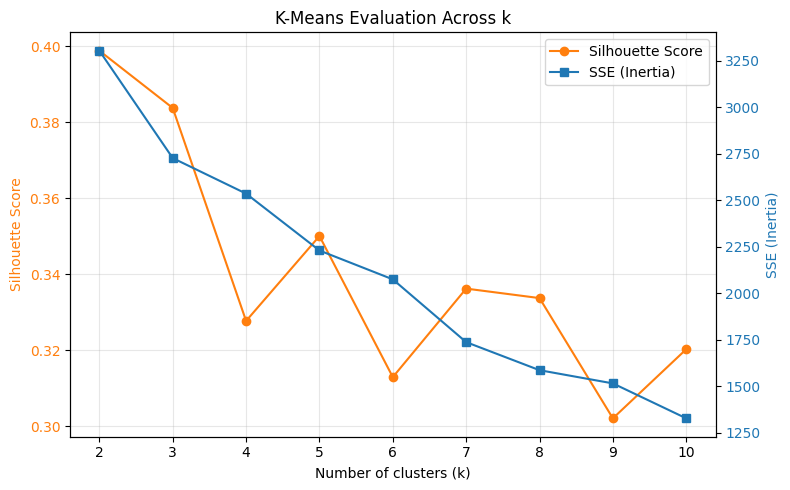

In [15]:
plot_df = results_df.sort_values("k")

fig, ax1 = plt.subplots(figsize=(8, 5))

# Left axis: silhouette
line1 = ax1.plot(
    plot_df["k"], plot_df["silhouette"],
    marker="o", color="tab:orange", label="Silhouette Score"
)
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Silhouette Score", color="tab:orange")
ax1.tick_params(axis="y", labelcolor="tab:orange")
ax1.grid(alpha=0.3)

# Right axis: SSE
ax2 = ax1.twinx()
line2 = ax2.plot(
    plot_df["k"], plot_df["sse"],
    marker="s", color="tab:blue", label="SSE (Inertia)"
)
ax2.set_ylabel("SSE (Inertia)", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best")

plt.title("K-Means Evaluation Across k")
plt.tight_layout()
plt.show()

## 3.c Model Selection and Comparison

Select the best model for this use case and justify your choice in Markdown. Compare its silhouette score with your best model from Assignment 2.
-
-
-


# 4. Conclusions
## 4.a Principal Components Scatter Plot
Generate a scatter plot of the first two principal components of the transformed data. Color the points by cluster assignment. Comment on the plot in Markdown and explain how it compares with your visualization from Assignment 2.

<Axes: xlabel='PC1', ylabel='PC2'>

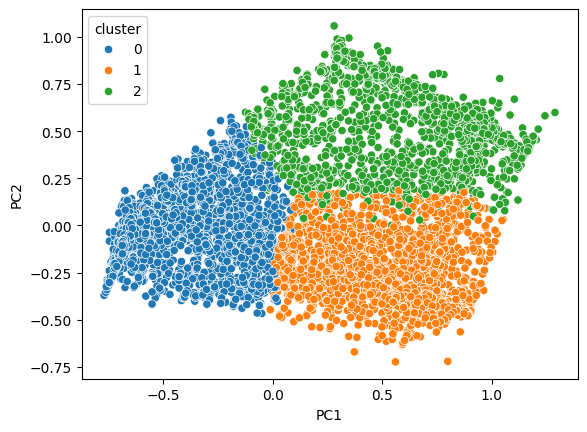

In [17]:
sns.scatterplot(data_t_2_df, x='PC1',y='PC2', hue='cluster', palette='tab10')

## 4.b Distribution Histogram
Generate a histogram showing the number of customers in each cluster and provide observations in Markdown, noting whether cluster sizes make sense.

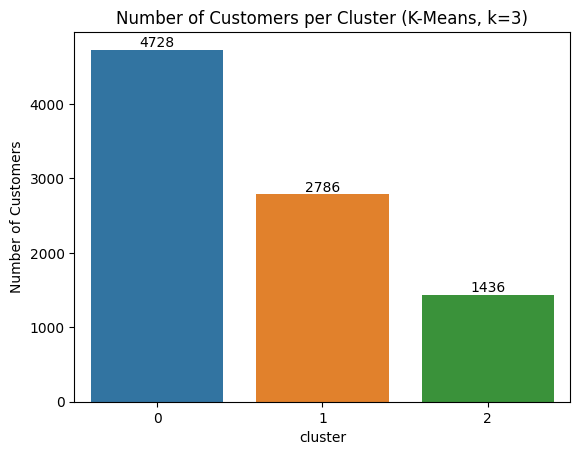

In [18]:
data_t_2_df["cluster"] = kmeans_results[3]["labels"]

ax = sns.countplot(data_t_2_df,x='cluster', palette='tab10', hue='cluster',legend=False)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster (K-Means, k=3)')
plt.show()


### Observations
-
-
-



## Feature analysis

The features that we identified as the best separators of our clusters are "Purchase installment frequency" and "One off Purchases frequency". These features separate our datapoints into clear identifiable values. 

### Purchase Instalment Frequency & One off purchases

We found that cluster number 1 shows low payment instalment frequency. This group of people also does not frequently make one off purchases noting that they are consistent on both frequency of payment and what they are buying. This group of people is stable, consistent, and most likely does not hold long term debt. Notable this is also the largest customer segment making up nearly the entirety of the other two clusters. 

Cluster number 2 frequently makes one off purchases existing on the upper half of the x axis. This demographic uses there credit card with less frequency and has a wide variety of purchase installments because of it. Overall their dominant behavior is making full upfront payments. This suggests financially comfortable customers who prefer traditional payment methods.

The 3rd cluster. shows moderate to high installment frequency (spread across 0.2-1.0 on x-axis) with variable one-off purchase frequency. The wide spread indicates diverse behavior within this group, potentially representing customers who actively use both payment methods or who prefer installment options for managing larger purchases while still making some one-off purchases.
​
​

## 4.c Cluster Demographics

This distribution makes sense when we consider our feature analysis. The 1st cluster is the largest, these are customers that carry low balances don't spend too much and are consistent about it. The 2nd cluster Carries a higher balance, these individuals are higher spenders carry balances and would be a smaller demographic of people. The third cluster found in between the two groups gravitate towards instalment plan options. This 3rd group understandable large, as they use the tools available to them, but not the biggest demographic as this requires extra planning and financial coherence to develop.  

# Cluster group 0


In [23]:
clean_cust_id["cluster"] = kmeans_results[3]["labels"]

In [24]:
df_cluster1 = clean_cust_id[clean_cust_id['cluster'] == 0]
df_cluster1.describe()


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,4728.000000,4728.000000,4728.000000,4728.000000,4728.00000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.0
mean,1705.353844,0.826169,296.110013,232.907862,63.39110,1356.571768,0.143562,0.081561,0.060843,0.185721,4.420051,2.680838,4145.263934,1477.335898,824.941667,0.068362,11.447335,0.0
std,2059.673948,0.276716,824.357238,712.946591,410.75464,2352.179433,0.168386,0.124714,0.120438,0.213489,7.776410,4.921284,3348.756515,2653.629608,2106.398220,0.190037,1.402413,0.0
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.037744,0.000000,6.000000,0.0
25%,198.917637,0.727273,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500.000000,316.507437,185.164394,0.000000,12.000000,0.0
50%,1082.054640,1.000000,54.760000,0.000000,0.00000,378.962318,0.083333,0.000000,0.000000,0.090909,2.000000,1.000000,3000.000000,676.820723,353.159236,0.000000,12.000000,0.0
75%,2285.202744,1.000000,320.000000,205.852500,10.12250,1817.958912,0.250000,0.100000,0.083333,0.272727,6.000000,4.000000,6000.000000,1541.426625,792.422506,0.000000,12.000000,0.0
max,16304.889250,1.000000,22500.000000,22101.780000,22500.00000,47137.211760,0.666667,0.583333,0.500000,1.500000,123.000000,186.000000,23000.000000,50721.483360,61031.618600,1.000000,12.000000,0.0


# Cluster Group 1


In [25]:
df_cluster2 = clean_cust_id[clean_cust_id['cluster'] == 1]
df_cluster2.describe()


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.0
mean,1138.840613,0.914410,1076.213112,275.007943,801.848844,502.190212,0.871642,0.099976,0.821061,0.070666,1.731874,20.984207,3939.993891,1402.219236,918.125869,0.238506,11.517229,1.0
std,1807.093596,0.190398,1262.707218,601.840674,941.070058,1483.401147,0.161024,0.149155,0.188338,0.155152,4.869821,21.341031,3223.595798,2017.789471,2999.113842,0.340232,1.372161,0.0
min,0.000000,0.000000,12.000000,0.000000,12.000000,0.000000,0.416667,0.000000,0.333333,0.000000,0.000000,0.000000,300.000000,0.000000,0.019163,0.000000,6.000000,1.0
25%,58.855452,0.909091,336.000000,0.000000,279.670000,0.000000,0.750000,0.000000,0.666667,0.000000,0.000000,10.000000,1500.000000,374.550186,155.588851,0.000000,12.000000,1.0
50%,340.657756,1.000000,638.025000,0.000000,502.970000,0.000000,1.000000,0.000000,0.888889,0.000000,0.000000,13.000000,3000.000000,785.697845,203.166010,0.000000,12.000000,1.0
75%,1412.701812,1.000000,1348.235000,270.272500,993.007500,94.941622,1.000000,0.166667,1.000000,0.083333,1.000000,24.000000,5500.000000,1652.051767,735.300043,0.425595,12.000000,1.0
max,16115.596400,1.000000,14686.100000,6345.650000,14686.100000,26268.699890,1.000000,0.583333,1.000000,1.000000,71.000000,347.000000,21500.000000,40627.595240,76406.207520,1.000000,12.000000,1.0


# Cluster Group 2



In [26]:
df_cluster2 = clean_cust_id[clean_cust_id['cluster'] == 2]
df_cluster2.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.0
mean,1926.411411,0.973467,3189.655564,2392.029227,797.626337,660.113655,0.892399,0.799331,0.478113,0.093716,2.335655,42.142061,6718.800329,3217.416822,768.588223,0.270231,11.747911,2.0
std,2481.923671,0.082880,4085.974558,3307.964556,1407.601455,1979.597901,0.143796,0.188651,0.383496,0.186228,5.950564,39.792975,4416.843305,4305.542735,1359.204867,0.371991,0.983751,0.0
min,0.000000,0.000000,8.400000,8.400000,0.000000,0.000000,0.500000,0.333333,0.000000,0.000000,0.000000,5.000000,300.000000,0.000000,3.197940,0.000000,6.000000,2.0
25%,279.919957,1.000000,1113.300000,829.300000,0.000000,0.000000,0.833333,0.666667,0.000000,0.000000,0.000000,17.000000,3037.500000,1034.989433,183.213876,0.000000,12.000000,2.0
50%,925.314895,1.000000,2110.075000,1507.775000,354.135000,0.000000,1.000000,0.833333,0.500000,0.000000,0.000000,29.000000,6000.000000,1919.418958,303.139824,0.000000,12.000000,2.0
75%,2620.806525,1.000000,3786.960000,2713.530000,993.500000,296.365478,1.000000,1.000000,0.833333,0.083333,1.000000,52.000000,9000.000000,3753.765398,883.962854,0.545455,12.000000,2.0
max,19043.138560,1.000000,49039.570000,40761.250000,15497.190000,29282.109150,1.000000,1.000000,1.000000,1.000000,51.000000,358.000000,30000.000000,46930.598240,21235.065300,1.000000,12.000000,2.0


## 4.d Conclusion: Summarizing Each Customer Group

### Cluster 1: The "Casual" Users (Low Activity)
These customers basically don't use their cards. They have super low balances averaging around 9% (0.089) and 75% of them are at the very bottom of the scale.

- Consumer Mindset: They almost never buy anything. The average purchase amount is tiny only being 0.5% (0.0052), and most of them have $0 for both one-off and installment buys.

- Behavior: They aren't taking out cash advances or making many transactions. Their full payment rate is also really low sitting at around 7% (0.069), probably because they just aren't using the card enough to care.

- Marketing suggestion: We should treat them like "window shoppers". To get them moving, we need persuasive reactivation emails with big limited-time discounts, or simple first purchase rewards to get them to use their card.

### Cluster 2: The "Big Spenders" (High-Value Loyalists)
This is bread and butter of the customers group. They actually use the card and carry high balances averaging around $2,050.

- Consumer Mindset: They spend a lot, averaging over $3,000 in purchases. They make a ton of one-off transactions that average around $2250 and use the card for almost everything.

- Behavior: They have the highest credit limits sitting around $6,750 on average and they actually pay their bills, with high average payments of around $3,260. About 25% of them pay in full every month.

- Marketing suggestion: Don't lose these people! We need to focus on VIP treatment for them. Something like a loyalty points system, exclusive experiences, and fee waivers could work. They are profitable because they use the card constantly, so we want to keep them happy and feeling "premium" for better retention. 

### Cluster 3: The "Budgeters" (Installment-Focused)
This group is right in the middle. They have moderate balances around $1,150 and are very active, but they are much more careful about how they spend.

- Consumer Mindset: They love installment plans. While they spend about $1,000 on average, a huge chunk of that is done through monthly payment plans rather than one-off big purchases.

- Behavior: Their installment frequency is high at about 75% (0.751), showing they prefer to break up their payments. They have mid-range credit limits of about $3,900 and are pretty good about making their minimum payments.

- Marketing suggestion: Pitch them buy now pay later offers. They care about budgeting and affordability, so we should market flexible payment plans or "interest-free for 6 months" bundles for bigger items to help them manage their money.
​

### Acknowledgment of Group Contributions:

- Alex: My contribution includes, doing the initial feature interpretation, helping with code refinement and adding cluster size display for all the methods and cluster sizes, and did the final cluster interpretation. Otherwise I attended all the team meetings we had scheduled and helped with input and feedback during the sessions. 

- Daniel: My contribution included the models training code, modeling exploration and selection, the dictionary design to store silhouettes scores and classification labels, boxplots code refactoring, general organization on the notebook and contributed to feature analysis in person sessions, providing feedback and tips for improvement. 

- Hunter: My contribution included, creating the initial file, building the structure of the document, and most of the initial exploration into the data. I also created the initial run of box plots where we analyzed features for further exploration. Other contributions were writing first draft of mark down for the conclusion, as well as mark down for heatmap interpretations. 

#### Reference List:

- ApX Machine Learning. (2026). Strategies for missing data: Imputation vs deletion. ApX. https://apxml.com/courses/intro-eda-course/chapter-2-data-loading-inspection-cleaning/missing-data-strategies
- FasterCapital. (n.d.). Installment: Installment insights: The strategy behind scheduled payments. https://fastercapital.com/content/Installment--Installment-Insights--The-Strategy-Behind-Scheduled-Payments.html
​